# Context Offloading

## Background from Drew's Post

Context offloading involves storing information outside the LLM's primary context to create a "scratchpad" for notes and intermediate thinking. Drew Breunig highlights Anthropic's research on this technique:

- **Anthropic's "think" tool** serves as a scratchpad for complex reasoning
- **Performance improvements up to 54%** in certain scenarios
- **Useful for tool output analysis, policy-heavy environments, and sequential decision making**
- **Reduces primary context load** while maintaining access to important information

Key insights from Drew's research:
- External scratchpads allow agents to save useful information during sessions
- Can be implemented as tool calls that write to files or as state object fields
- Essential for managing complex multi-step processes
- Helps maintain context quality while reducing token usage

## Context Offloading in Practice

When humans solve tasks, we take notes and remember things for future, related tasks. Agents are also gaining these capabilities! Note-taking via a "[scratchpad](https://www.anthropic.com/engineering/claude-think-tool)" is one approach to persist information while an agent is performing a task. The central idea is to save information outside of the context window so that it's available to the agent on-demand. [Anthropic's multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) illustrates a clear example of this:

> The LeadResearcher begins by thinking through the approach and saving its plan to Memory to persist the context, since if the context window exceeds 200,000 tokens it will be truncated and it is important to retain the plan.

It's worth noting that this scratchpad can be implemented in a few different ways. It could be a [tool call](https://www.anthropic.com/engineering/claude-think-tool) that [writes to a file](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem). It could also just be a field in a runtime [state object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that persists during the session. In either case, the intuition is clear: scratchpads let agents save useful information during a session to help them accomplish tasks.

### Scratchpad writing in LangGraph

LangGraph was designed with first-class support of both thread-scoped ([short-term](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory)) and [long-term memory](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory). Short-term memory uses [checkpointing](https://langchain-ai.github.io/langgraph/concepts/persistence/) to persist [agent state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) across all steps of an agent session. This is extremely useful as s "scratchpad", allowing you to write information to state during agent execution and fetch it later as needed.

The state object in LangGraph serves as the central data structure that gets passed between nodes in your graph. You can decide the schema for this state object, but it's common to use a Python dictionary. The state acts as a shared scratchpad; each node can read from and write to specific fields. Let's create `TypedDict` a state object.

In [ ]:
from typing import TypedDict

from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

# Define a graph state with two fields
class State(TypedDict):
    """State schema for the joke generator workflow.
    
    Attributes:
        topic: The topic for joke generation
        joke: The generated joke content
    """
    topic: str
    joke: str

## State-Based Scratchpads

Once we've defined a state object, we can use it as a scratchpad. A [StateGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is LangGraph's primary abstraction for building stateful workflows where each node can read from and modify shared state.

**Key concepts:**
- **Nodes** are processing steps that receive current state and return updates
- **Edges** connect nodes to create execution flow (linear, conditional, or cyclical)
- **State** serves as a shared scratchpad between nodes

The mechanism for selecting context depends on implementation:
- **Tool-based**: Agent reads scratchpad via tool calls
- **State-based**: Developer controls what state parts are exposed to agents

This provides fine-grained control over context presentation to LLM calls.

In [2]:
from typing import TypedDict

from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

# Define a graph state with two fields
class State(TypedDict):
    """State schema for the joke generator workflow.
    
    Attributes:
        topic: The topic for joke generation
        joke: The generated joke content
    """
    topic: str
    joke: str

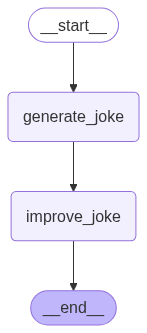

In [17]:
import getpass
import os

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph


def _set_env(var: str) -> None:
    """Set environment variable if not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set up environment and initialize model
_set_env("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)


def generate_joke(state: State) -> dict[str, str]:
    """Generate an initial joke about the topic.
    
    Args:
        state: Current state containing the topic
        
    Returns:
        Dictionary with the generated joke
    """
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def improve_joke(state: State) -> dict[str, str]:
    """Improve an existing joke by adding wordplay.
    
    This demonstrates selecting context from state - we read the existing
    joke from state and use it to generate an improved version.
    
    Args:
        state: Current state containing the original joke
        
    Returns:
        Dictionary with the improved joke
    """
    print(f"Initial joke: {state['joke']}")
    
    # Select the joke from state to present it to the LLM
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


# Build the workflow with two sequential nodes
workflow = StateGraph(State)

# Add both joke generation nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)

# Connect nodes in sequence
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", "improve_joke")
workflow.add_edge("improve_joke", END)

# Compile the workflow
chain = workflow.compile()

# Display the workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

In [18]:
# Execute the workflow to see context selection in action
joke_generator_state = chain.invoke({"topic": "cats"})

# Display the final state with rich formatting
console.print("\n[bold blue]Final Workflow State:[/bold blue]")
pprint(joke_generator_state)

Initial joke: Why don't cats ever win races?

Because they always paws right before the finish line!


Final Workflow State:

{
│   'topic': 'cats',
│   'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"
}

## Memory 

Scratchpads helps agents solve a task within a given session, but sometimes agents benefit from remembering things across *many* sessions! [Reflexion](https://arxiv.org/abs/2303.11366) introduced the idea of reflection following each agent turn and re-using these self-generated hints. [Generative Agents](https://ar5iv.labs.arxiv.org/html/2304.03442) created memories synthesized periodically from collections of past agent feedback.

These concepts made their way into popular products like [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq), [Cursor](https://forum.cursor.com/t/0-51-memories-feature/98509), and [Windsurf](https://docs.windsurf.com/windsurf/cascade/memories), which all have mechanisms to auto-generate long-term memories based on user-agent interactions.

### Memory writing in LangGraph

Checkpointing saves the state of your graph at each step. These are saved to a [thread](https://langchain-ai.github.io/langgraph/concepts/persistence/). Each thread is referenced by a unique identifier and typically represents a single interaction with an agent. It it analogous to a single "chat thread" with ChatGPT, for example.

LangGraph’s long-term memory allows you to persist specific context *across threads* with your agent. It is flexible, allowing you to save [individual files](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) (e.g., a user profile) or [collections](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of memories. 

LangGraph’s long-term memory uses the [BaseStore](https://langchain-ai.github.io/langgraph/reference/store/) interface, which is a key-value store. It can be use in memory, as we show below in this notebook. It also can be used with [LangGraph Platform deployments](https://langchain-ai.github.io/langgraph/concepts/persistence/#langgraph-platform).

Let's create an `InMemoryStore` for use across a few different sessions in our notebook.

In [5]:
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store for long-term memory
store = InMemoryStore()

# Define namespace as a tuple (user_id, application_context)
namespace = ("rlm", "joke_generator")

# Write context as a key-value pair to the namespace
store.put(
    namespace,                             # namespace for organizing data
    "last_joke",                          # key for this specific piece of data
    {"joke": joke_generator_state["joke"]} # value to store
)

We'll talk more about selecting context from the namespace in the next notebook.

For now, we can just use the [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to view items within a namespace and see that we wrote to it.

In [12]:
# Select (retrieve) the joke from memory
retrieved_joke = store.get(namespace, "last_joke").value

# Display the retrieved context
console.print("\n[bold green]Retrieved Context from Memory:[/bold green]")
pprint(retrieved_joke)

Retrieved Context from Memory:

{'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}

Now, let's just embed what we did inside a LangGraph workflow.

We compile our workflow with two arguments: 

* `checkpointer`: Save graph state at each step to a thread 
* `store`: Persist context across threads

In [13]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# Initialize storage components
checkpointer = InMemorySaver()
memory_store = InMemoryStore()


def generate_joke(state: State, store: BaseStore) -> dict[str, str]:
    """Generate a joke with memory-aware context selection.
    
    This function demonstrates selecting context from memory before
    generating new content, ensuring consistency and avoiding duplication.
    
    Args:
        state: Current state containing the topic
        store: Memory store for persistent context
        
    Returns:
        Dictionary with the generated joke
    """
    # Select prior joke from memory if it exists
    prior_joke = store.get(namespace, "last_joke")
    if prior_joke:
        prior_joke_text = prior_joke.value["joke"]
        print(f"Prior joke: {prior_joke_text}")
    else:
        print("Prior joke: None!")

    # Generate a new joke that differs from the prior one
    prompt = (
        f"Write a short joke about {state['topic']}, "
        f"but make it different from any prior joke you've written: {prior_joke_text if prior_joke else 'None'}"
    )
    msg = llm.invoke(prompt)

    # Store the new joke in memory for future context selection
    store.put(namespace, "last_joke", {"joke": msg.content})

    return {"joke": msg.content}


# Build the memory-aware workflow
workflow = StateGraph(State)
workflow.add_node("generate_joke", generate_joke)

# Connect the workflow
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile with both checkpointing and memory store
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

In [14]:
# Execute the workflow with the first thread
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: None!


In [8]:
# Execute the workflow with thread-based configuration
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

# Display the workflow result with rich formatting
console.print("\n[bold cyan]Workflow Result (Thread 1):[/bold cyan]")
pprint(joke_generator_state)

Existing joke: No existing joke


Workflow Result (Thread 1):

{
│   'topic': 'cats',
│   'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"
}

Because we compiled with a checkpointer, we can see the [latest state](https://langchain-ai.github.io/langgraph/concepts/persistence/#get-state) of the graph!

In [15]:
# Get the latest state of the graph
latest_state = chain.get_state(config)

console.print("\n[bold magenta]Latest Graph State:[/bold magenta]")
pprint(latest_state)

Latest Graph State:

StateSnapshot(
│   values={
│   │   'topic': 'cats',
│   │   'joke': "Why don't cats ever win at poker?\n\nBecause they can't help but purr when they have a good hand!"
│   },
│   next=(),
│   config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0636ed-67fc-6fca-8001-47c4eca91406'
│   │   }
│   },
│   metadata={'source': 'loop', 'step': 1, 'parents': {}},
│   created_at='2025-07-18T00:33:34.473820+00:00',
│   parent_config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0636ed-4ffc-61c8-8000-121bc404e313'
│   │   }
│   },
│   tasks=(),
│   interrupts=()
)

In [11]:
# Execute the workflow with a different thread ID
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

# Display the result showing memory persistence across threads
console.print("\n[bold yellow]Workflow Result (Thread 2):[/bold yellow]")
pprint(joke_generator_state)

Existing joke: {'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}


Workflow Result (Thread 2):

{
│   'topic': 'cats',
│   'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"
}

We fetch the prior joke from memory and pass it to an LLM to improve it!

In [16]:
# Execute the workflow with a second thread to demonstrate memory persistence
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: Why don't cats ever win at poker?

Because they can't help but purr when they have a good hand!
